Replicate paper

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
class SpotRateModel:
    def __init__(self,
                 r0,
                 a,
                 b,
                 theta,
                 sigma,
                 lamda,
                 gamma,
                 mu,
                 h,
                 t,
                 T,
                 m,
                 model_name):
        self.r0 = r0
        self.a = a*t
        self.b = b
        self.theta = theta*t
        self.sigma = sigma*t
        self.lamda = lamda*t
        self.gamma = gamma
        self.mu = mu
        self.h = h
        self.t = t
        self.T = T
        self.m = m
        self.delta_t = (T-t)/m
        self.model_name = model_name
        
    def spot_rates(self):
        spot_rates = []
        for i in range(self.m+1):
            if i==0:
                spot_rates.append(self.r0)
            else:
                prev_spot_rate = spot_rates[i-1]
                if self.model_name == "vasicek":
                    spot_rates.append(prev_spot_rate + (self.theta - self.a*prev_spot_rate*self.t - self.lamda*self.sigma)*self.delta_t + self.sigma*np.random.normal()*np.sqrt(self.delta_t) + np.random.normal(self.mu, self.gamma)*np.random.poisson(self.h*self.delta_t))
                if self.model_name == "cir":
                    spot_rates.append(prev_spot_rate + (self.theta - self.a*prev_spot_rate - self.lamda*self.sigma*np.sqrt(prev_spot_rate*self.t))*self.delta_t + self.sigma*np.sqrt(prev_spot_rate*self.t)*np.random.normal()*np.sqrt(self.delta_t) + np.random.normal(self.mu, self.gamma)*np.random.poisson(self.h*self.delta_t))
        
        return pd.DataFrame(spot_rates, index=np.arange(self.m+1), columns=["SPOT_RATE"])
            

            

In [71]:
spot_rate_model = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0.05,
                 T=20,
                 m=365,
                 model_name='vasicek')

In [102]:
class MonteCarloSimulation:
    def __init__(self, 
                 num_simulations,
                 spot_rate_model,
                 mc_type):
        self.num_simulations = num_simulations
        self.spot_rate_model = spot_rate_model
        self.mc_type = mc_type

    def simulate(self):
        spot_rates = pd.DataFrame()
        for i in range(self.num_simulations):
            spot_rates[i] = self.spot_rate_model.spot_rates()['SPOT_RATE']  
        
        bond_prices = spot_rates
        for i in range(self.num_simulations):
            bond_prices[i] = np.exp(-bond_prices[i].cumsum()*self.spot_rate_model.delta_t)
            
        bond_prices = bond_prices.mean(axis=1)
        return bond_prices

In [103]:
mc = MonteCarloSimulation(1000, spot_rate_model, "")

In [104]:
sr = mc.simulate()

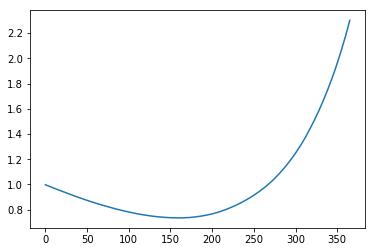

In [106]:
sr.plot()